## ICV21_Assignment #3
- 전기정보공학부
- 2016-13343
- 유상윤

In [106]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import copy
import math

## Taking Panoramic pictures
took pictures of my room, made into RGB format, resize into 256*256 size

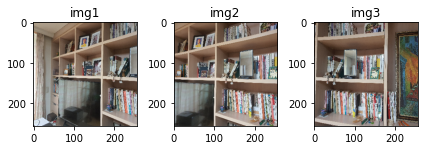

In [107]:
# Taking Panoramic pictures

I1 = cv.imread('images/img1.jpg')
I2 = cv.imread('images/img2.jpg')
I3 = cv.imread('images/img3.jpg')

I1= cv.cvtColor(I1,cv.COLOR_BGR2RGB)
I2= cv.cvtColor(I2,cv.COLOR_BGR2RGB)
I3= cv.cvtColor(I3,cv.COLOR_BGR2RGB)

I1 = cv.resize(I1, dsize=(256,256))
I2 = cv.resize(I2, dsize=(256,256))
I3 = cv.resize(I3, dsize=(256,256))

fig, ax = plt.subplots(1, 3)

ax[0].imshow(I1, cmap='gray')
ax[1].imshow(I2, cmap='gray')
ax[2].imshow(I3, cmap='gray')
ax[0].set_title("img1")
ax[1].set_title("img2")
ax[2].set_title("img3")

fig.tight_layout()
plt.show()

## Feature Extraction

convert color to grey images

As given in assignment requirement, used SIFT feature in OpenCV version

Set to extract about 200~300 points each image

For evenly distributed feature points, I tuned the contrastThreshold and edgeThreshold as needed.

Number of points in img1: 292
Number of points in img2: 269
Number of points in img3: 290


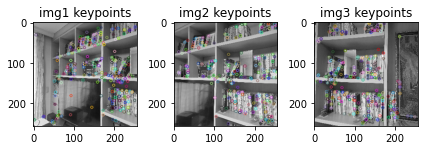

In [127]:
# Featrue Extraction

I1_gray= cv.cvtColor(I1,cv.COLOR_RGB2GRAY)
I2_gray= cv.cvtColor(I2,cv.COLOR_RGB2GRAY)
I3_gray= cv.cvtColor(I3,cv.COLOR_RGB2GRAY)

sift = cv.SIFT_create(contrastThreshold=0.09, edgeThreshold=15)
kp1, des1 = sift.detectAndCompute(I1_gray,None)
print("Number of points in img1:", len(kp1))
I1_kp = copy.deepcopy(I1)
cv.drawKeypoints(I1_gray,kp1,I1_kp)

sift = cv.SIFT_create(contrastThreshold=0.12, edgeThreshold=10)
kp2, des2 = sift.detectAndCompute(I2_gray,None)
print("Number of points in img2:", len(kp2))
I2_kp = copy.deepcopy(I2)
cv.drawKeypoints(I2_gray,kp2,I2_kp)

sift = cv.SIFT_create(contrastThreshold=0.11, edgeThreshold=10)
kp3, des3 = sift.detectAndCompute(I3_gray,None)
print("Number of points in img3:", len(kp3))
I3_kp = copy.deepcopy(I3)
cv.drawKeypoints(I3_gray,kp3,I3_kp)

fig, ax = plt.subplots(1, 3)

ax[0].imshow(I1_kp, cmap='gray')
ax[1].imshow(I2_kp, cmap='gray')
ax[2].imshow(I3_kp, cmap='gray')
ax[0].set_title("img1 keypoints")
ax[1].set_title("img2 keypoints")
ax[2].set_title("img3 keypoints")

fig.tight_layout()
plt.show()

## Feature Matching

In the requirement, v1_ubcmatch in Matlab and kd-tree library such as ANN is given to use. In python, equivalent for it seems to be FLannBasedMatcher in OpenCV. 

I set the threshold to best/second < 0.7.

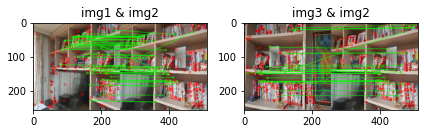

In [128]:
# Feature Matching

def feature_matching(d1, d2, threshold):
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)

    flann = cv.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(d1,d2,k=2)
    matches_above_ratio = []
    matchesMask = [[0,0] for i in range(len(matches))]
    # ratio test
    for i,(m,n) in enumerate(matches):
        if m.distance < threshold*n.distance:
            matches_above_ratio.append(m)
            matchesMask[i] = [1,0]    
    return matches, matches_above_ratio, matchesMask

all_matches12, matches12, mask12 = feature_matching(des1, des2, 0.7)
all_matches32, matches32, mask32 = feature_matching(des3, des2, 0.7)

draw_params = dict(matchColor = (0,255,0),
                    singlePointColor = (255,0,0),
                    matchesMask = mask12,
                    flags = cv.DrawMatchesFlags_DEFAULT)
I12 = cv.drawMatchesKnn(I1,kp1,I2,kp2,all_matches12,None,**draw_params)

draw_params = dict(matchColor = (0,255,0),
                    singlePointColor = (255,0,0),
                    matchesMask = mask32,
                    flags = cv.DrawMatchesFlags_DEFAULT)
I32 = cv.drawMatchesKnn(I3,kp3,I2,kp2,all_matches32,None,**draw_params)

fig, ax = plt.subplots(1, 2)

ax[0].imshow(I12, cmap='gray')
ax[1].imshow(I32, cmap='gray')
ax[0].set_title("img1 & img2")
ax[1].set_title("img3 & img2")

fig.tight_layout()
plt.show()


## Homography Estimation using RANSAC

I have implemented all of the algorithm in the requirement including Optional steps

In [129]:
# define DLT for use
def DLT(P1, P2):
    A = []
    for p1, p2 in zip(P1, P2):
        x, y = p1[0], p1[1]
        u, v = p2[0], p2[1]
        A.append( [x, y, 1, 0, 0, 0, -u*x, -u*y, -u] )
        A.append( [0, 0, 0, x, y, 1, -v*x, -v*y, -v] )
    A = np.asarray(A)
    U, S, Vh = np.linalg.svd(A, full_matrices=True)
    h = Vh[-1]
    H = h.reshape(3, 3)
    return H

In [130]:
# define symmetric_transfer_error for distance measure
def symmetric_transfer_error(x, x_p, H):
    x_star = np.matmul(H, np.concatenate((np.transpose(x), np.ones((1,len(x))))))
    x_star = (x_star[0:2]/x_star[-1]).T
    d1 = np.sum((x_star-x_p)**2, 1)
    x_star = np.matmul(np.linalg.inv(H), np.concatenate((np.transpose(x_p), np.ones((1,len(x))))))
    x_star = (x_star[0:2]/x_star[-1]).T
    d2 = np.sum((x_star-x)**2, 1)
    return d1+ d2

In [131]:
# Homography Estimation using RANSAC

t = 1.25 # threshold for distance
p = 0.99 # constant for Adaptive determination of # of samples in RANSAC
s = 4 # constant for Adaptive determination of # of samples in RANSAC

def get_H_RANSAC(k1, k2, matches):
    n_match = len(matches)
    x, x_p = [], []
    for match in matches:
        x.append(list(k1[match.queryIdx].pt))
        x_p.append(list(k2[match.trainIdx].pt))
    x = np.array(x)
    x_p = np.array(x_p)

    N = math.inf
    sample_count = 0
    max_n_inlier = 0
    best_inlier = None

    # Adaptive determination of # of samples for RANSAC
    while N > sample_count:
        sample = np.random.choice(range(n_match), 4, replace=False)
        x_sample, x_p_sample = x[sample], x_p[sample]

        H = DLT(x_sample, x_p_sample)

        is_inlier = (symmetric_transfer_error(x, x_p, H)<t)
        n_inlier = np.count_nonzero(is_inlier)

        sigma = 1-n_inlier/n_match
        if n_inlier == 0: N = math.inf
        else: N = np.log(1-p)/np.log(1-(1-sigma)**s)
        sample_count += 1
        if max_n_inlier < n_inlier:
            max_n_inlier = n_inlier
            best_inlier = is_inlier

    # iterate last two steps in given Algorithm until convergencee
    # if inlier repeats for 10 times, see as convergence
    old_inlier = best_inlier
    i = 0
    while i < 10:
        H = DLT(x[old_inlier], x_p[old_inlier])
        is_inlier = (symmetric_transfer_error(x, x_p, H)<t)

        if (old_inlier == is_inlier).all(): i += 1
        else: i = 0

        old_inlier = is_inlier
    total_st_error = np.mean(np.sqrt(symmetric_transfer_error(x, x_p, H)))
    return H, total_st_error

H12, e12 = get_H_RANSAC(kp1, kp2, matches12)
H32, e32 = get_H_RANSAC(kp3, kp2, matches32)

## Warping Images

maketform and imtransform in MATLAB can be used as given requirement.
In python OpenCV, perspectiveTransform and warpPerspective is a similiar method.

To stich all 3 images, I stiched img 1,2 img 2,3 each, then stiched all 3 with center of each images same.

In [132]:
# stich 2 images
def warpImages(img1, img2, H):

  rows1, cols1 = img1.shape[:2]
  rows2, cols2 = img2.shape[:2]

  list_of_points_1 = np.float32([[0,0], [0, rows1],[cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2)
  temp_points = np.float32([[0,0], [0,rows2], [cols2,rows2], [cols2,0]]).reshape(-1,1,2)

  list_of_points_2 = cv.perspectiveTransform(temp_points, H)

  list_of_points = np.concatenate((list_of_points_1,list_of_points_2), axis=0)

  [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
  [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)
  
  translation_dist = [-x_min,-y_min]
  
  H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])

  output_img = cv.warpPerspective(img2, H_translation.dot(H), (x_max-x_min, y_max-y_min))
  output_img[translation_dist[1]:rows1+translation_dist[1], translation_dist[0]:cols1+translation_dist[0]] = img1
  return output_img

In [133]:
# stich all 3 images
def stich3Images(img1, img2, img3, H12, H23):
    img12 = warpImages(img2, img1, H12)
    img23 = warpImages(img2, img3, H32)
    rows1, cols1 = img12.shape[:2]
    rows2, cols2 = img23.shape[:2]

    result = np.zeros((max(rows1, rows2), cols1+cols2-256, 3), dtype=int)
    rows, cols = result.shape[:2]
    result[int(rows/2-rows1/2):int(rows/2+rows1/2), 0:cols1] = img12
    result[int(rows/2-rows2/2):int(rows/2+rows2/2), -cols2-1:-1] = img23
    return result

## Result Image

### total symmetric transfer error(mean of square(all distance))

In [134]:
print("H12 error:", e12)
print("H32 error:", e32)

H12 error: 10.134966251520547
H32 error: 8.189703930607573


### Pairwise Matching Results

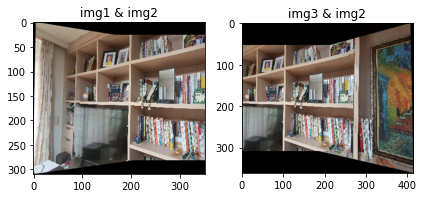

In [135]:
I_match12 = warpImages(I2, I1, H12)
I_match32 = warpImages(I2, I3, H32)

fig, ax = plt.subplots(1, 2)

ax[0].imshow(I_match12, cmap='gray')
ax[1].imshow(I_match32, cmap='gray')
ax[0].set_title("img1 & img2")
ax[1].set_title("img3 & img2")

fig.tight_layout()
plt.show()

### Final mosaic image

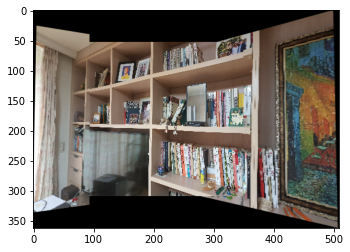

In [136]:
I_result = stich3Images(I1, I2, I3, H12, H32)
plt.imshow(I_result)
plt.show()

### Discussion

Center is slightly different, so the result image is a bit awkward.

The overall image seems to be well stiched.

There are hyperparameters that I have manually set, which is thresholds when feature extraction, and ratio threshold of best and second matches when feature matching. 

I have tuned the parameters for best performance, but I still don't know if it is the best. More research seems to be needed.
